# Notes (à enlever à la fin)

The report must include:
- a short introduction of the context and goals
- the whole processing pipeline (including the methods that didn't work!!). Every step should be justified (not only the results but the interpretation is important). Don't forget to comment your code where needed (and to keep it clean)!
- a conclusion/discussion on the results of your pipeline

Timeline
1. Read the images.
2. Check that the images are of sufficient quality and that they do not require preprocessing.
3. Suggest a method for segmenting nematodes.
4. Extract geometric descriptors for each nematode that could reflect its living or dead
status.
5. Confirm by statistical test the effect of the drug.

# Pistes à tester (à enlever à la fin)

- local thresholding
- Split-and-merge


# Introduction

# Imports des librairies

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from skimage import filters, segmentation, feature, measure
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from scipy import signal
from PIL import Image
from collections import Counter
from skimage.morphology import skeletonize
import networkx as nx

/home/lilian/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Import des images

In [3]:
l_img = []

for filename in os.listdir("Data"):
    img_path = os.path.join("Data", filename)
    img = np.array(Image.open(img_path))
    l_img.append(img)

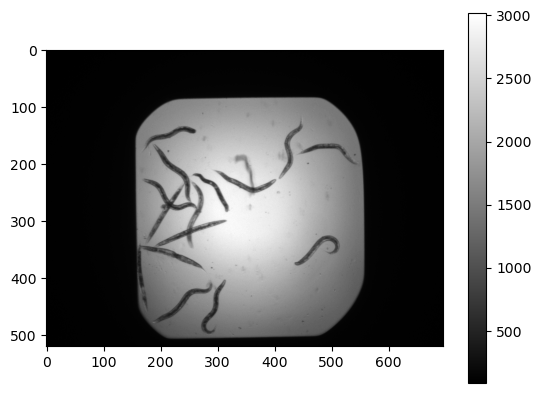

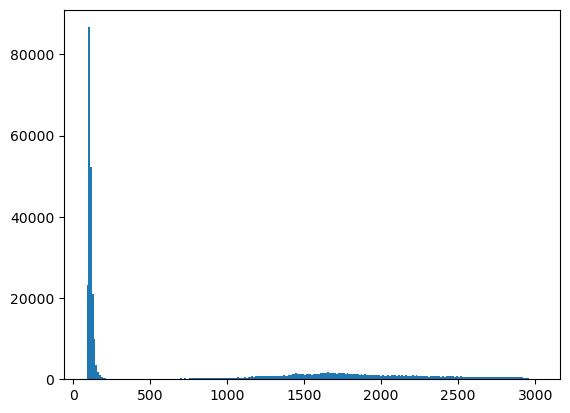

In [4]:
plt.imshow(l_img[0], cmap="gray")
plt.colorbar()
plt.show()

plt.hist(l_img[0].flatten(), bins = 255)
plt.show()

# Preprocessing des images

## Dilatation des histogrammes

In [5]:
def stretch(img):
    mini = np.min(img)
    maxi = np.max(img)
    return (255*((img-mini)/(maxi-mini)))

In [6]:
l_img_stretched = []

for img in l_img :
    l_img_stretched.append(stretch(img).astype(int).copy())

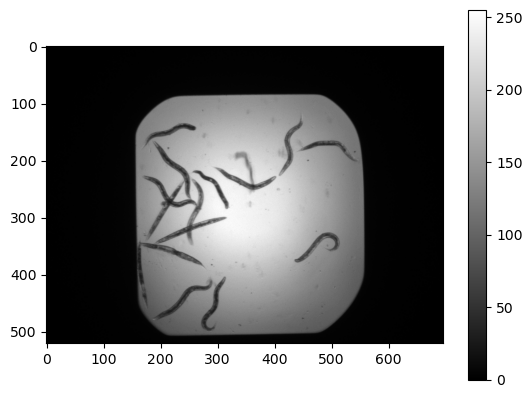

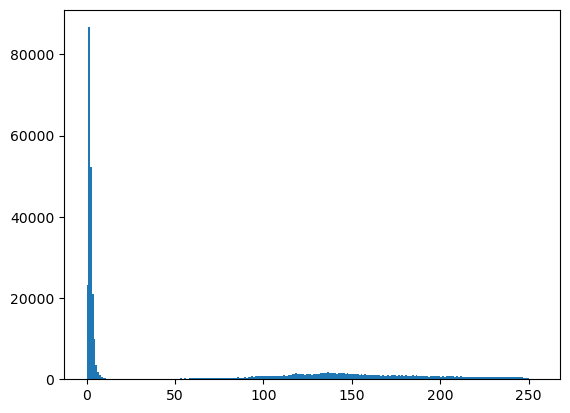

In [7]:
plt.imshow(l_img_stretched[0], cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()
plt.hist(l_img_stretched[0].flatten(), bins = 255)
plt.show()

# Seuillage

## Seuil global

## Seuil local

In [8]:
l_img_local_thresholded = []

block_size = 51
for img in l_img_stretched:
    local_thresh = filters.threshold_local(img, block_size, offset=10)
    l_img_local_thresholded.append(img < local_thresh)


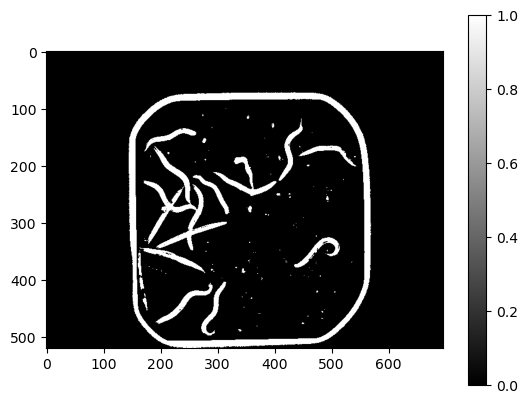

In [9]:
plt.imshow(l_img_local_thresholded[0], cmap="gray")
plt.colorbar()
plt.show()

# Supression du contour du récipiant

In [10]:
l_window = []

window_threshold = 8

for img in l_img_stretched:
    window = img>window_threshold
    l_window.append(window)

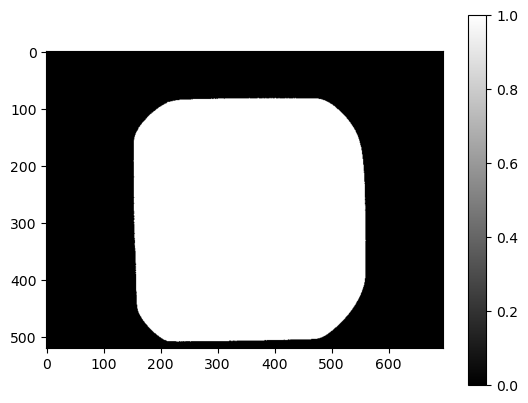

In [11]:
plt.imshow(l_window[0], cmap="gray", vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

In [12]:
l_window_countour = []

for window in  l_window :
    l_window_countour.append(stretch(filters.sobel(window))>30)


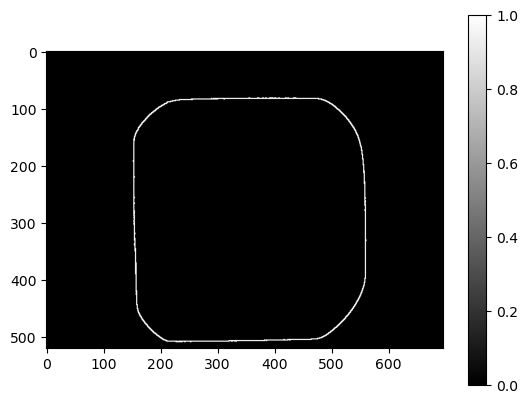

In [13]:
plt.imshow(l_window_countour[0], cmap="gray")
plt.colorbar()
plt.show()

In [14]:
l_wide_window_negative_countour = []

width = 21

for negative_countour in l_window_countour:
    l_wide_window_negative_countour.append(signal.convolve2d(negative_countour,np.ones((width,width)),mode='same')==0)


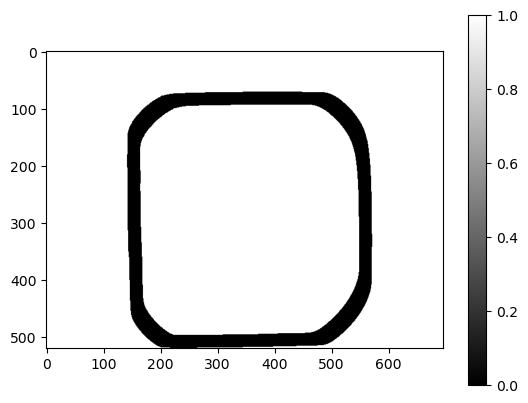

In [15]:
plt.imshow(l_wide_window_negative_countour[0], cmap="gray")
plt.colorbar()
plt.show()

In [16]:
l_img_local_thresholded_nematods = []

for i,img in enumerate(l_img_local_thresholded):
    l_img_local_thresholded_nematods.append(np.multiply(np.multiply(img, l_wide_window_negative_countour[i]),l_window[i]))

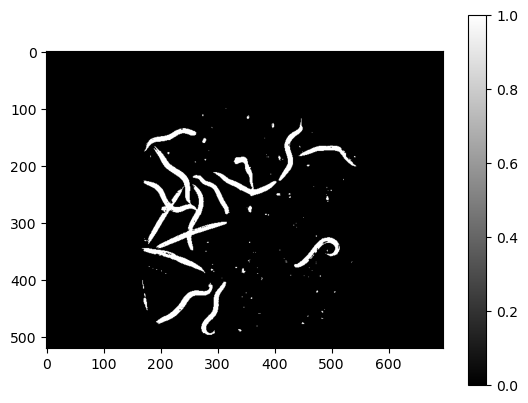

In [17]:
plt.imshow(l_img_local_thresholded_nematods[0], cmap="gray")
plt.colorbar()
plt.show()

# Opérations Morphologiques

In [18]:
def erosion(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    ero_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) < np.sum(structuring_element) :
                ero_img[i,j] = 0
            else :
                ero_img[i,j] = 1
    return ero_img


In [19]:
def dilatation(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    dil_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) > 0 :
                dil_img[i,j] = 1
            else :
                dil_img[i,j] = 0
    return dil_img


In [20]:
def multiple_erosions_and_dilataions(bin_img,l):
    for letter in l:
        if letter=='e':
            bin_img = erosion(bin_img).copy()
        elif letter=='d':
            bin_img = dilatation(bin_img).copy()
    return bin_img

In [21]:
l_img_morph = []

for img in l_img_local_thresholded_nematods:
    l_img_morph.append(multiple_erosions_and_dilataions(img,['d','d','e','e']))

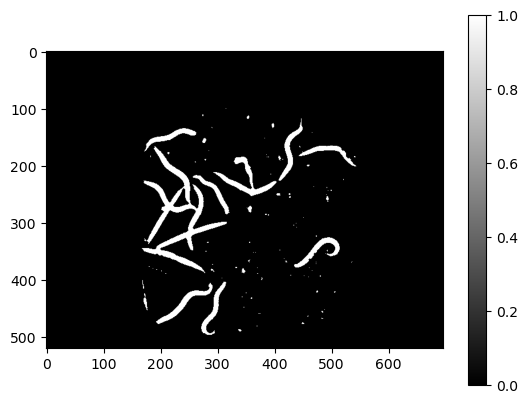

In [22]:
plt.imshow(l_img_morph[0], cmap="gray")
plt.colorbar()
plt.show()

# Enlever les trous restant

In [23]:
l_img_morph_fill = []

for img in l_img_morph:
    l_img_morph_fill.append(filters.median(img))

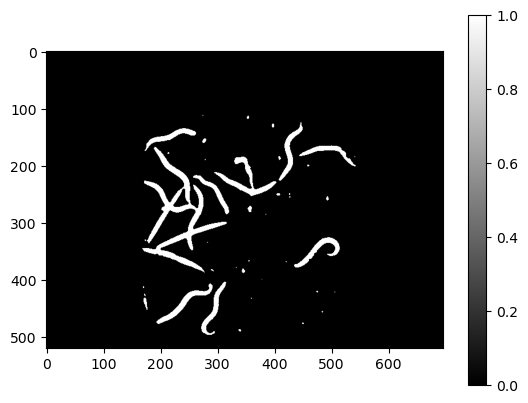

In [24]:
plt.imshow(l_img_morph_fill[0], cmap="gray")
plt.colorbar()
plt.show()

# Squelettisation 

In [25]:
l_skeleton = []

for img in l_img_morph_fill:
    l_skeleton.append(skeletonize(img))

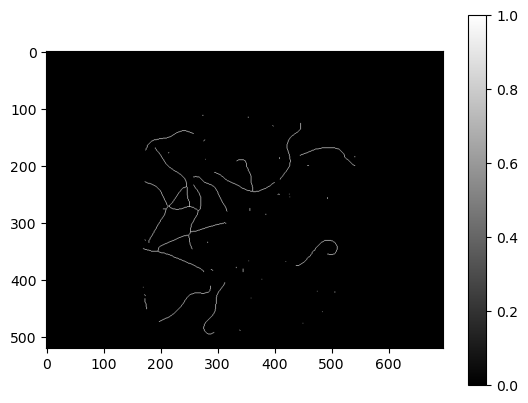

In [26]:
plt.imshow(l_skeleton[0], cmap="gray")
plt.colorbar()
plt.show()

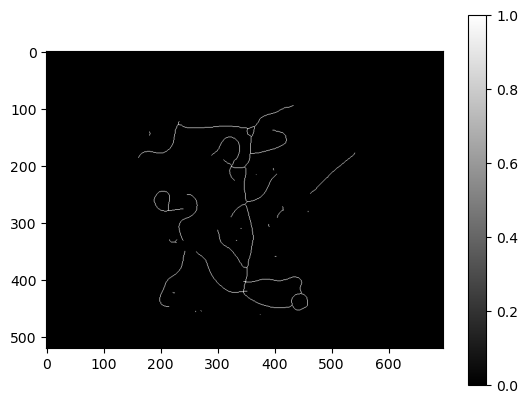

In [27]:
plt.imshow(l_skeleton[12], cmap="gray")
plt.colorbar()
plt.show()

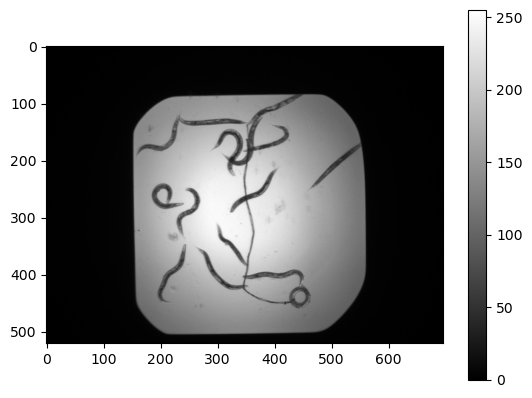

In [28]:
plt.imshow(l_img_stretched[12], cmap="gray")
plt.colorbar()
plt.show()

# Labélisation des nématodes

## Graphe de connectivité des pixels des squelettes

In [29]:
def adjacency_matrix(image):
    n = len(image)
    m = len(image[0])

    G = nx.Graph()
    for i in range (0, n):
        for j in range (0,m):
            voisins = [(i,j-1), (i, j+1), (i-1, j), (i+1, j), (i+1,j+1), (i+1, j-1), (i-1, j-1), (i-1, j+1)]
            voisins = list(map(lambda x : x if ((0 <= x[0] < n) and ( 0 <= x[1] < m)) else None , voisins))
            adjacence = list(map(lambda x : (image[i][j] and image[x[0]][x[1]]) if x is not None else None , voisins))

            for k in range(len(voisins)):
                if ((voisins[k] is not None) and (adjacence[k] == True)):
                    G.add_edge((i,j),(voisins[k][0], voisins[k][1]))
          
    return G

In [30]:
l_skeleton_graph = [adjacency_matrix(skeleton) for skeleton in l_skeleton]

## Extraction des squelettes candidats

In [31]:
def all_nematods_candidates(G_connexe):
    l_end = [n for n, d in G_connexe.degree() if d == 1]
    l_end_done = []
    l_candidates = []
    for end in l_end:
        l_end_done.append(end)
        l_parcours = [end]
        current = list(G_connexe.neighbors(end))[0]

        def rec_parcours(current, l_parcours):
            if current in l_end:
                if current not in l_end_done:
                    l_parcours.append(current)
                    return l_parcours
            for neighbor in list(G_connexe.neighbors(current)):
                if neighbor in l_parcours[:-1]:
                    l_parcours.append(current)
                    return l_parcours
            
            l_parcours.append(current)
            l_neighbors = list(G_connexe.neighbors(current))
            
            return [rec_parcours(new_current, l_parcours.copy()) for new_current in l_neighbors if new_current not in l_parcours]
        
        l_candidates += rec_parcours(current, l_parcours)
    
    def flatten_l_l_tuples(object):
        res = []
        if isinstance(object, list):
            if all(isinstance(x, tuple) for x in object):
                if len(object)>0:
                    res.append(object)
            else:
                for l in object:
                    res.extend(flatten_l_l_tuples(l))
        return res

    return flatten_l_l_tuples(l_candidates)

In [32]:
l_l_skeleton_candidates = []
for i,skeleton_graph in enumerate(l_skeleton_graph):
    l_l_skeleton_candidates.append([])
    for connexe_component in list(nx.connected_components(skeleton_graph)):
        sub_skeleton_graph = skeleton_graph.subgraph(connexe_component).copy()
        l_l_skeleton_candidates[i].append(all_nematods_candidates(sub_skeleton_graph))

In [33]:
len(l_l_skeleton_candidates)

24

### Exemple

In [70]:
i = 1
j = 3

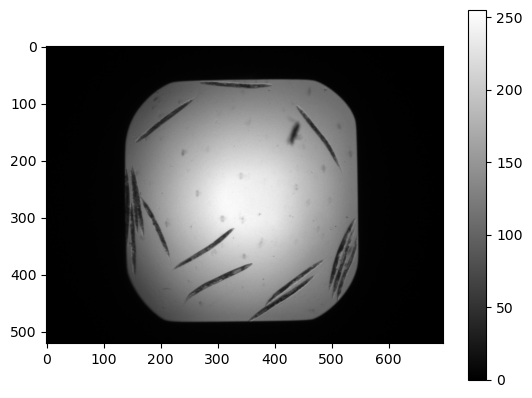

In [73]:
plt.imshow(l_img_stretched[i], cmap="gray")
plt.colorbar()
plt.show()

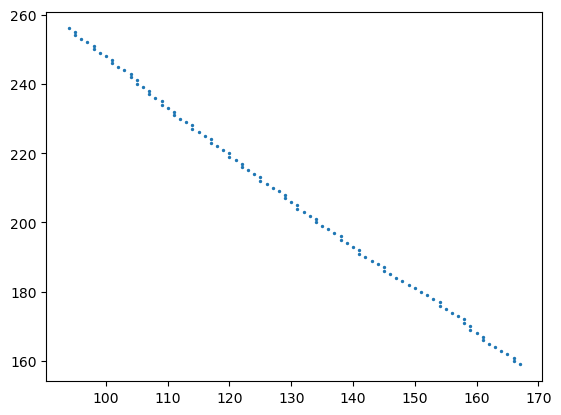

In [74]:
components = list(nx.connected_components(l_skeleton_graph[i]))
sub_skeleton_graph = l_skeleton_graph[i].subgraph(components[j]).copy()

nodes = list(sub_skeleton_graph)
x_coords = [n[0] for n in nodes]
y_coords = [n[1] for n in nodes]

plt.scatter(x_coords, y_coords, s=2)
plt.show()

In [75]:
len(l_l_skeleton_candidates[i][j])

1

In [76]:
l_l_skeleton_candidates[i]

[[[(69, 309),
   (69, 310),
   (69, 311),
   (69, 312),
   (69, 313),
   (69, 314),
   (69, 315),
   (69, 316),
   (69, 317),
   (69, 318),
   (69, 319),
   (69, 320),
   (69, 321),
   (69, 322),
   (69, 323),
   (69, 324),
   (69, 325),
   (69, 326),
   (69, 327),
   (69, 328),
   (69, 329),
   (69, 330),
   (69, 331),
   (69, 332),
   (69, 333),
   (69, 334),
   (70, 335),
   (70, 336),
   (70, 337),
   (69, 338),
   (69, 339),
   (69, 340),
   (69, 341),
   (69, 342),
   (69, 343),
   (69, 344),
   (69, 345),
   (69, 346),
   (69, 347),
   (70, 348),
   (70, 349),
   (70, 350),
   (70, 351),
   (70, 352),
   (70, 353),
   (70, 354),
   (70, 355),
   (70, 356),
   (70, 357),
   (70, 358),
   (70, 359),
   (70, 360),
   (70, 361),
   (70, 362),
   (70, 363),
   (70, 364),
   (70, 365),
   (70, 366),
   (70, 367),
   (70, 368),
   (70, 369),
   (70, 370),
   (70, 371),
   (70, 372),
   (70, 373),
   (70, 374),
   (70, 375),
   (70, 376),
   (70, 377),
   (69, 378),
   (69, 379),
   (69

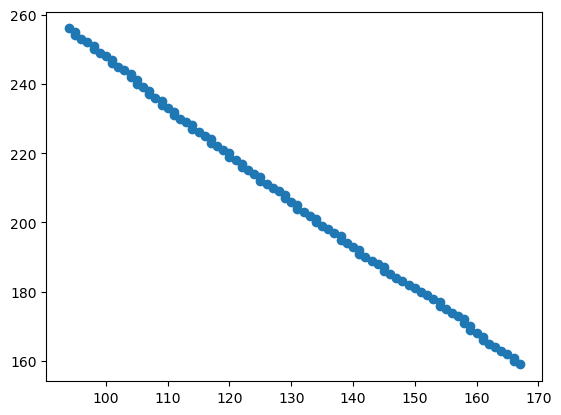

In [77]:
for c in l_l_skeleton_candidates[i][j]:
    nodes = list(c)
    x_coords = [n[0] for n in nodes]
    y_coords = [n[1] for n in nodes]

    plt.scatter(x_coords, y_coords, alpha=1)
    plt.show()

# Calcul des caractéristiques géométriques

In [78]:
def is_a_nematod(candidate):
    return

# Analyse des résultats

# Conclusion